In [1]:
# U-Net을 이용해 이미지 세그먼테이션을 수행
# 이미지 세그먼테이션 이미지를 픽셀 단위로 끊어 분류하는 문제
# 이미지의 각 픽셀이 어떤 범주에 해당하는지 예측하도록 신경망을 학습
# 동물사진과 배경을 분리하도록 신경망을 학습

In [2]:
# 정보의 압축(인코더)과 복원(디코더)을 이용한 구조를 인코더-디코더 구조
# U-Net은 인코더 디코더 구조를 이용한 모델, 인코더의 출려과 디코더의 출력을 합쳐서 다음 층의 입력으로 사용

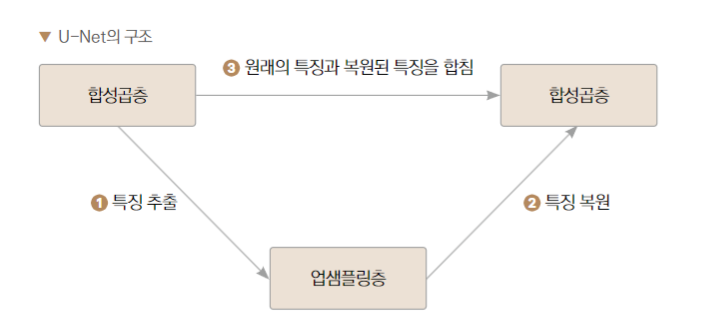

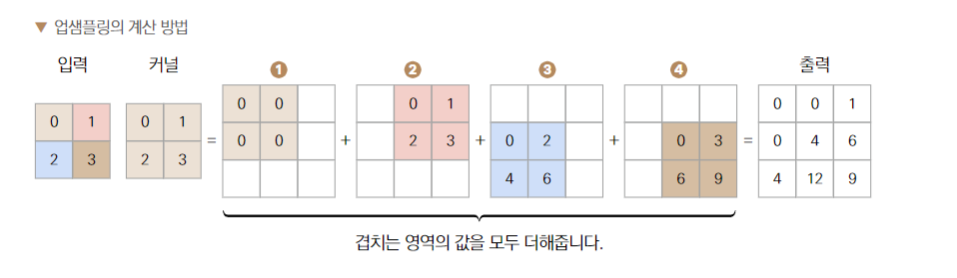

In [3]:
# 업셈플링 : 이미지에서 추출한 특징을 이용해 이미지를 복원하는 과정 혹은 이미지를 키우는 기법

In [4]:
# 동물에 해당하는 부분을 0, 동물의 배경의 경계를 1, 배경을 2로 표현

In [5]:
# 이진분류로  사용   배경은0 이고 동물과 경계 1로 이미지를 변경

In [6]:
import torch
import numpy as np

In [7]:
from torch.utils.data.dataset import Dataset
from PIL import Image

In [8]:
!rm -rf /content/annotations
!rm -rf /content/images

In [9]:
!tar -zxvf '/content/drive/MyDrive/Colab Notebooks/U_Net/annotations.tar.gz'

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
annotations/trimaps/._pomeranian_180.png
annotations/trimaps/pomeranian_180.png
annotations/trimaps/._pomeranian_181.png
annotations/trimaps/pomeranian_181.png
annotations/trimaps/._pomeranian_182.png
annotations/trimaps/pomeranian_182.png
annotations/trimaps/._pomeranian_183.png
annotations/trimaps/pomeranian_183.png
annotations/trimaps/._pomeranian_184.png
annotations/trimaps/pomeranian_184.png
annotations/trimaps/._pomeranian_185.png
annotations/trimaps/pomeranian_185.png
annotations/trimaps/._pomeranian_186.png
annotations/trimaps/pomeranian_186.png
annotations/trimaps/._pomeranian_187.png
annotations/trimaps/pomeranian_187.png
annotations/trimaps/._pomeranian_188.png
annotations/trimaps/pomeranian_188.png
annotations/trimaps/._pomeranian_189.png
annotations/trimaps/pomeranian_189.png
annotations/trimaps/._pomeranian_19.png
annotations/trimaps/pomeranian_19.png
annotations/trimaps/._pomeranian_190.png
annotations/trimaps/pomeranian_190.png
annota

In [10]:
!tar -zxvf '/content/drive/MyDrive/Colab Notebooks/U_Net/images.tar.gz'

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
images/american_bulldog_194.jpg
images/Birman_175.jpg
images/american_bulldog_178.jpg
images/staffordshire_bull_terrier_93.jpg
images/Egyptian_Mau_58.jpg
images/havanese_44.jpg
images/english_cocker_spaniel_97.jpg
images/Ragdoll_111.jpg
images/american_pit_bull_terrier_159.jpg
images/english_setter_134.jpg
images/english_setter_87.jpg
images/wheaten_terrier_198.jpg
images/pug_180.jpg
images/boxer_172.jpg
images/Sphynx_197.jpg
images/german_shorthaired_2.jpg
images/British_Shorthair_9.jpg
images/pug_89.jpg
images/japanese_chin_39.jpg
images/Ragdoll_20.jpg
images/american_bulldog_111.jpg
images/yorkshire_terrier_112.jpg
images/Persian_88.jpg
images/pug_9.jpg
images/Birman_40.jpg
images/British_Shorthair_272.jpg
images/havanese_7.jpg
images/pomeranian_154.jpg
images/beagle_49.jpg
images/British_Shorthair_94.jpg
images/Persian_90.jpg
images/staffordshire_bull_terrier_30.jpg
images/samoyed_113.jpg
images/english_cocker_spaniel_46.jpg
images/Abyssinian_22.

In [11]:
import glob
annotation_filelists =  glob.glob('/content/annotations/trimaps/*.png')
images_filelists = glob.glob('/content/images/*.jpg')
len(annotation_filelists), len(images_filelists)

(7390, 7390)

In [12]:
import matplotlib.pyplot as plt
from PIL import Image

In [13]:
image = Image.open(images_filelists[0])
annotation = Image.open(annotation_filelists[0])



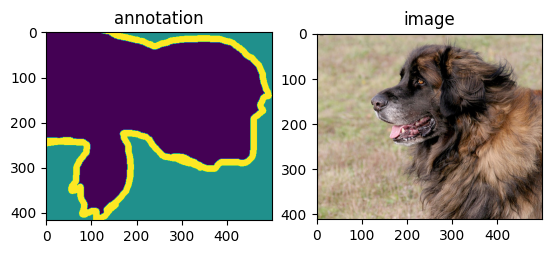

In [14]:
plt.subplot(1,2,1)
plt.title("annotation")
plt.imshow(annotation)
plt.subplot(1,2,2)
plt.title("image")
plt.imshow(image)
plt.show()

In [15]:
import glob
import torch
import numpy as np

from torch.utils.data.dataset import Dataset
from PIL import Image


class Pets(Dataset):
   def __init__(self, path_to_img, 
                path_to_anno, 
                train=True, 
                transforms=None, 
                input_size=(128, 128)):

       # ❶ 정답과 입력 이미지를 이름순으로 정렬
       self.images = sorted(glob.glob(path_to_img+"/*.jpg"))
       self.annotations = sorted(glob.glob(path_to_anno + "/*.png"))


       # ❷ 데이터셋을 학습과 평가용으로 나눔
       self.X_train = self.images[:int(0.8 * len(self.images))]
       self.X_test = self.images[int(0.8 * len(self.images)):]
       self.Y_train = self.annotations[
                :int(0.8 * len(self.annotations))]
       self.Y_test = self.annotations[
                int(0.8 * len(self.annotations)):]

       self.train = train  # 학습용 데이터 평가용 데이터 결정 여부
       self.transforms = transforms  # 사용할 데이터 증강
       self.input_size = input_size  # 입력 이미지 크기
   def __len__(self):  # 데이터 개수를 나타냄
       if self.train:
           return len(self.X_train)  # 학습용 데이터셋 길이
       else:
           return len(self.X_test)   # 평가용 데이터셋 길이
   def preprocess_mask(self, mask):  # ➋ 정답을 변환해주는 함수
       mask = mask.resize(self.input_size)
       mask = np.array(mask).astype(np.float32) 
       mask[mask != 2.0] = 1.0 
       mask[mask == 2.0] = 0.0 
       mask = torch.tensor(mask)  
       return mask
   def __getitem__(self, i):  # i번째 데이터와 정답을 반환
       if self.train:  # 학습용 데이터                      
           X_train = Image.open(self.X_train[i]).convert('RGB')
           X_train = self.transforms(X_train)
           Y_train = Image.open(self.Y_train[i])
           Y_train = self.preprocess_mask(Y_train)

           return X_train, Y_train
       else:  # 평가용 데이터              
           X_test = Image.open(self.X_test[i]).convert('RGB')
           X_test = self.transforms(X_test)
           Y_test = Image.open(self.Y_test[i])
           Y_test = self.preprocess_mask(Y_test)

           return X_test, Y_test

In [16]:
# U-Net 모델 정의

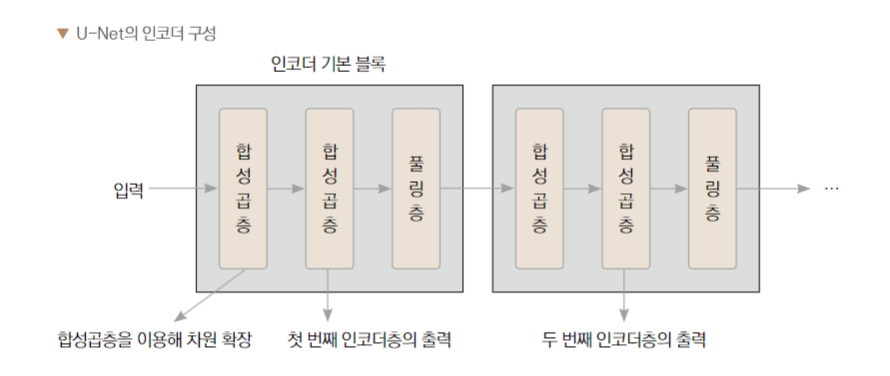

In [17]:
import torch.nn as nn

class UNet(nn.Module):
   def __init__(self):
       super(UNet, self).__init__()
       # ❶ U-Net의 인코더에 사용되는 은닉층
       self.enc1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
       self.enc1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
       self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

       self.enc2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
       self.enc2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
       self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

       self.enc3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
       self.enc3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
       self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

       self.enc4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
       self.enc4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
       self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

       self.enc5_1 = nn.Conv2d(512, 1024, kernel_size=3, padding=1)
       self.enc5_2 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
       # 디코더에 사용되는 은닉층
       self.upsample4 = nn.ConvTranspose2d(512, 512, 2, stride=2)
       self.dec4_1 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
       self.dec4_2 = nn.Conv2d(512, 256, kernel_size=3, padding=1)

       self.upsample3 = nn.ConvTranspose2d(256, 256, 2, stride=2)
       self.dec3_1 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
       self.dec3_2 = nn.Conv2d(256, 128, kernel_size=3, padding=1)

       self.upsample2 = nn.ConvTranspose2d(128, 128, 2, stride=2)
       self.dec2_1 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
       self.dec2_2 = nn.Conv2d(128, 64, kernel_size=3, padding=1)

       self.upsample1 = nn.ConvTranspose2d(64, 64, 2, stride=2)
       self.dec1_1 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
       self.dec1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
       self.dec1_3 = nn.Conv2d(64, 1, kernel_size=1)


       # 합성곱과 업샘플링층의 활성화 함수
       self.relu = nn.ReLU()
       # 출력층의 활성화함수
       self.sigmoid = nn.Sigmoid()
   def forward(self, x):
       x = self.enc1_1(x)
       x = self.relu(x)
       e1 = self.enc1_2(x)  # ❶ 디코더에서 사용하기 위해 따로 변수를 지정
       e1 = self.relu(e1)   # ❷ 합성곱층의 출력의 활성화
       x = self.pool1(e1)

       x = self.enc2_1(x)
       x = self.relu(x)
       e2 = self.enc2_2(x)
       e2 = self.relu(e2)
       x = self.pool2(e2)

       x = self.enc3_1(x)
       x = self.relu(x)
       e3 = self.enc3_2(x)
       e3 = self.relu(e3)
       x = self.pool3(e3)

       x = self.enc4_1(x)
       x = self.relu(x)
       e4 = self.enc4_2(x)
       e4 = self.relu(e4)
       x = self.pool4(e4)

       x = self.enc5_1(x)
       x = self.relu(x)
       x = self.enc5_2(x)
       x = self.relu(x)
       x = self.upsample4(x)

       # ❶ 인코더의 출력과 업샘플링된 이미지를 함침
       x = torch.cat([x, e4], dim=1)
       x = self.dec4_1(x)
       x = self.relu(x)
       x = self.dec4_2(x)
       x = self.relu(x)

       x = self.upsample3(x)
       x = torch.cat([x, e3], dim=1)
       x = self.dec3_1(x)
       x = self.relu(x)
       x = self.dec3_2(x)
       x = self.relu(x)

       x = self.upsample2(x)
       x = torch.cat([x, e2], dim=1)
       x = self.dec2_1(x)
       x = self.relu(x)
       x = self.dec2_2(x)
       x = self.relu(x)

       x = self.upsample1(x)
       x = torch.cat([x, e1], dim=1)
       x = self.dec1_1(x)
       x = self.relu(x)
       x = self.dec1_2(x)
       x = self.relu(x)
       x = self.dec1_3(x)

       x = torch.squeeze(x)  # ➋ 흑백 이미지를 그리기 위해 채널을 없앰

       return x

In [18]:
import tqdm

from torchvision.transforms import Compose
from torchvision.transforms import ToTensor, Resize
from torch.optim.adam import Adam
from torch.utils.data.dataloader import DataLoader

device = "cuda" if torch.cuda.is_available() else "cpu"


# 데이터 전처리 정의
transform = Compose([
   Resize((128, 128)),
   ToTensor()
])

In [19]:
# 학습 데이터
path_to_image = '/content/images'
path_to_annotation = '/content/annotations/trimaps'
train_set = Pets(path_to_img=path_to_image,
                 path_to_anno=path_to_annotation,
                 transforms=transform)

# 평가용 데이터
test_set = Pets(path_to_img=path_to_image,
                path_to_anno=path_to_annotation, 
                transforms=transform, 
                train=False)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set)

In [20]:
# 디코더는 이미지 크기를 두배로 늘려주는 업샘플링을 1회 거친뒤, 합성곱을 2번 사용
# 마지막 블록은 합성곱을 3번 사용 - 신경망의 출력을 결정
# 픽셀이 0에 가깝다면 배경, 1에 가깝다면 동물
# 출력층의 활성화 함수는 시그모이드 함수


In [21]:
# 모델 정의
model = UNet().to(device)


# 학습률 정의
learning_rate = 0.0001

# 최적화 정의
optim = Adam(params=model.parameters(), lr=learning_rate)


In [23]:
for epoch in range(10):
   iterator = tqdm.tqdm(train_loader)

   for data, label in iterator:
       optim.zero_grad()  # 이전 루프의 기울기 초기화

       preds = model(data.to(device))  # 모델의 예측값 출력
       loss = nn.BCEWithLogitsLoss()(
           preds, 
           label.type(torch.FloatTensor).to(device))  # 손실 계산
       loss.backward()  # 오차 역전파

       optim.step()  # 최적화

       iterator.set_description(f"epoch{epoch+1} loss:{loss.item()}")

torch.save(model.state_dict(), "./UNet.pth")  # 모델 가중치 저장

epoch10 loss:0.20354944467544556: 100%|██████████| 185/185 [01:50<00:00,  1.68it/s]


In [24]:
# 모델성능평가  unsqueeze()함수를 사용
# unsqueeze(A.dim)   A를 dim 차원을 추가

In [60]:
import matplotlib.pyplot as plt
model.load_state_dict(torch.load('/content/UNet.pth',map_location=device))

<All keys matched successfully>

In [66]:
data,label = test_set[0]
data.shape

torch.Size([3, 128, 128])

In [67]:
pred = model(torch.unsqueeze(data.to(device), dim=0)) > 0.5

In [68]:
pred=pred.squeeze().cpu().numpy()

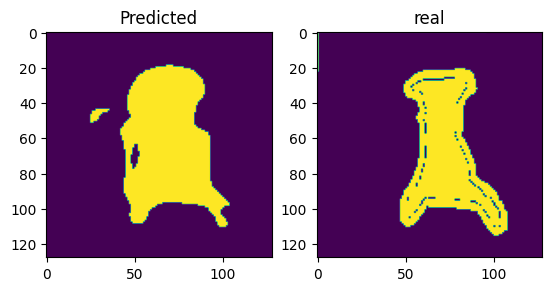

In [69]:
with torch.no_grad():
  plt.subplot(1,2,1)
  plt.title('Predicted')
  plt.imshow(pred)
  plt.subplot(1,2,2)
  plt.title('real')
  plt.imshow(label)
